In [1]:
import soundfile
import glob
import numpy as np
import filters
import scipy
import pickle
import ntpath
import os
from random import shuffle

import tensorflow as tf
import prettytensor as pt

from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling1D
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.layers import Dropout
from keras.utils import plot_model

%matplotlib inline

import matplotlib.pyplot as plt

/home/amit/workspace/learning_dp/.venv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


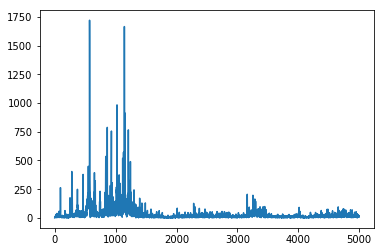

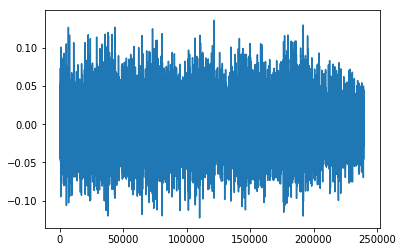

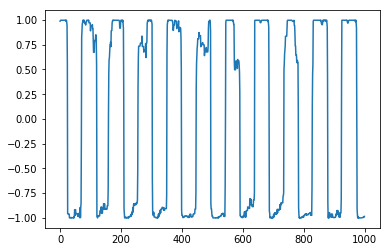

In [2]:
def read_and_split(filepath):
    samples, fs = soundfile.read(filepath)
    samples = np.array(samples)
    sound_samples = samples[:, 0]
    sound_samples = sound_samples - np.mean(sound_samples)
    tach_samples = samples[:, 4]
    tach_samples = tach_samples - np.mean(tach_samples)
    tach_samples = scipy.signal.medfilt(tach_samples, kernel_size=[5])
    return sound_samples, tach_samples, fs
f = "soundfiles/V1_Srpi-lab-rec-001_DT1526569732092.wav"
sound_samples, tach_samples, fs = read_and_split(f)
x = np.abs(np.fft.fft(sound_samples))
plt.plot(x[:len(x)/2][:5000])
plt.figure()

plt.plot(sound_samples)
plt.figure()
plt.plot(tach_samples[:1000])
plt.show()


In [3]:
def calc_speed(tach_samples, fs, number_elements, samples_for_claculation=3000):
    positive = np.where(tach_samples > 0)[0]
    positive_roll = np.roll(positive, 1)
    sub = positive - positive_roll
    sub[0] = 1
    cross_positive = positive[np.where(sub!=1)[0]]
    negative = np.where(tach_samples < 0)[0]
    negative_roll = np.roll(negative, 1)
    sub = negative - negative_roll
    sub[0] = 1
    cross_negative = negative[np.where(sub!=1)[0]]
    cross_vector = np.zeros(len(tach_samples))
    cross_vector[cross_positive] = 1
    cross_vector[cross_negative] = 1
    neg_pos_concat = np.concatenate((np.diff(cross_positive), np.diff(cross_negative)))
    speed = 1 / ((np.mean(neg_pos_concat)/ fs) * number_elements)
    return speed, tach_samples, cross_vector

number_elements = 20
speed, tach_samples_partial,cross_vector = calc_speed(tach_samples, fs, number_elements)

print "The speed is ", speed


The speed is  24.743144972980186


In [4]:
sound_interval_ms = 200.
sound_stride_ms = 200.
batch_size = 128
expected_fs = 48000
sound_interval_samples = int(fs * sound_interval_ms/1000)
input_shape = (None, sound_interval_samples, 1)

def batch_generator(batch_size, file_dir="soundfiles/*.wav"):
    """
    Generator function for creating random batches of training-data.
    """
    x_batch = []
    y_batch = []
    while True:
        for f in glob.glob(file_dir):
            sound_samples, tach_samples, fs = read_and_split(f)
            assert expected_fs == fs
            sound_interval_samples = int(fs*sound_interval_ms/1000)
            sound_stride_samples = int(fs*sound_stride_ms/1000)
            num_of_strides = (len(sound_samples)-sound_interval_samples)/sound_stride_samples
            for n in range(int(num_of_strides)):
                interval_samples = sound_samples[n*sound_stride_samples:n*sound_stride_samples+sound_interval_samples]
                interval_tach = tach_samples[n*sound_stride_samples:n*sound_stride_samples+sound_interval_samples]
                speed, tach_samples_partial,cross_vector = calc_speed(interval_tach, fs, number_elements=20)
                x_batch.append(interval_samples)
                y_batch.append(speed)
                if len(x_batch) >= batch_size:
                    x_batch = np.expand_dims(x_batch, axis=2)
                    yield (np.array(x_batch), np.array(y_batch))
                    x_batch = []
                    y_batch = []

In [5]:
generator = batch_generator(batch_size=batch_size)

In [6]:
x_batch, y_batch = next(generator)
print x_batch.shape, y_batch.shape

(128, 9600, 1) (128,)


In [7]:
model = Sequential()
model.add(InputLayer(batch_input_shape=input_shape))
model.add(Conv1D(filters=20, kernel_size=200 ,strides=1, activation= 'relu', name="conv1"))
model.add(MaxPooling1D(pool_size=15, strides=15))
model.add(Conv1D(filters=50, kernel_size=100 ,strides=1, activation= 'relu', name="conv3")) 
model.add(MaxPooling1D(pool_size=25, strides=25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9600, 1)           0         
_________________________________________________________________
conv1 (Conv1D)               (None, 9401, 20)          4020      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 626, 20)           0         
_________________________________________________________________
conv3 (Conv1D)               (None, 527, 50)           100050    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1050)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               134528    
__________

In [8]:
from keras.optimizers import Adam

optimizer = Adam(lr=1e-3)

In [9]:
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['accuracy'])

In [10]:
callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callback_tensorboard = TensorBoard(log_dir='./engine_raw_singal_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_early_stopping = EarlyStopping(monitor='loss',
                                        patience=5, verbose=1)

path_checkpoint = 'keras'
checkpointer = ModelCheckpoint(filepath=path_checkpoint, verbose=1, save_best_only=True)

callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callbacks = [
    callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr
]

In [11]:
history = model.fit_generator(generator=generator,
                    epochs=200,
                    steps_per_epoch=500,
                    callbacks=callbacks
                   )
model_json = model.to_json()
with open("model_raw.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_raw.h5")
print("Saved model to disk")


Epoch 1/130
10/10 [==============================] - 12s 1s/step - loss: 342.0072 - acc: 0.0000e+00

Epoch 00001: loss improved from inf to 342.00716, saving model to keras
Epoch 2/130
10/10 [==============================] - 3s 257ms/step - loss: 80.7008 - acc: 0.0000e+00

Epoch 00002: loss improved from 342.00716 to 80.70078, saving model to keras
Epoch 3/130
10/10 [==============================] - 4s 366ms/step - loss: 33.4076 - acc: 0.0000e+00

Epoch 00003: loss improved from 80.70078 to 33.40764, saving model to keras
Epoch 4/130
10/10 [==============================] - 4s 366ms/step - loss: 36.0496 - acc: 0.0000e+00

Epoch 00004: loss did not improve from 33.40764

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000475.
Epoch 5/130
10/10 [==============================] - 5s 484ms/step - loss: 22.8025 - acc: 0.0000e+00

Epoch 00005: loss improved from 33.40764 to 22.80250, saving model to keras
Epoch 6/130
10/10 [==============================] - 7s 663ms/step

KeyboardInterrupt: 